In [847]:
reset -f

In [848]:
import torch
import torch.nn as nn

import numpy as np
import matplotlib.pyplot as plt 

from pyDOE import lhs 

In [849]:
torch.manual_seed(1234)
np.random.seed(1234)

In [850]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Working on {device}")

Working on cpu


In [ ]:
def equinoctial_to_cometary(equin_coord, t0):  # (a, h, k, p, q, L) --> (q, e, i, Omega, omega, T)
    t_0 = t0
    # Gravitational constant for the Sun (AU^3/day^2)
    mu = np.power(0.01720209895, 2)

    e = np.sqrt(equin_coord[1]**2 + equin_coord[2]**2)
    Omega = np.arctan2(equin_coord[4], equin_coord[3])
    i = 2 * np.arctan(np.sqrt(equin_coord[3]**2 + equin_coord[4]**2))

    omega = np.arctan2(equin_coord[2], equin_coord[1]) - Omega
    omega = omega % (2 * np.pi)  # Ensure omega is within the range [0, 2*pi)

    M = equin_coord[5] - Omega - omega
    M = M % (2 * np.pi)  # Ensure M is within the range [0, 2*pi)

    q_cometary = equin_coord[0] * (1 - e)

    # Compute orbital period (T_orb)
    T_orb = 2 * np.pi * np.sqrt(np.power(equin_coord[0], 3) / mu)
    n = 2 * np.pi / T_orb  # Compute the mean motion (n)
    T = t_0 - M / n  # Compute the time of perihelion passage (T)

    # Ensure T is within a sensible range (e.g., the last perihelion passage)
    while T > t_0:
        T -= T_orb
    while T < t_0 - T_orb:
        T += T_orb
        
    return np.array((q_cometary, e, i, Omega, omega, T))

In [ ]:
y_init_equin = np.array((1.4597513976025835, 0.285859684022060, 0.187526292392717, -0.001113623441851, -0.001969823345975, 34.9412629996062))  # from .eq0 orbfit file
y_true_0 = equinoctial_to_cometary(y_init_equin, t0 = 57291.958166082) # t0 for 2015RN35

In [ ]:
# Data importing
columns_input = ['rho', 'rho_dot', 'alpha', 'delta', 'alpha_dot', 'delta_dot']
columns_output = ['rho', 'rho_dot']

# Importo i dati sotto forma di DataFrame
data_input_1 = pd.read_csv('datas_orbfit/2015RN35_N1.ar_sample', skiprows=9, delim_whitespace=True,
                            names=['i', 'j', 'rho', 'rho_dot', 'cc', 'succ', 'chi', 'Jac (AR-MOV)', 'E_Sun', 'E_Earth', 'unknown'])
data_test_1 = pd.read_csv('datas_orbfit/2015RN35_N1.start_ar_sample', skiprows=9, delim_whitespace=True, 
                            names=['i', 'j', 'rho', 'rho_dot', 'cc', 'succ', 'chi', 'Jac (AR-MOV)', 'E_Sun', 'E_Earth', 'unknown'])

Att_1 = pd.read_csv('/home/FGeroni/Università/PhD/Code/datas/2015RN35_N1.ar_sample', skiprows = 1, nrows = 1, delim_whitespace=True, names = ['alpha', 'delta', 'alpha_dot', 'delta_dot'])

Att_1 = pd.concat([Att_1] * len(data_input_1), ignore_index=True)
data_input_1 = pd.concat([data_input_1, Att_1], axis = 1)

data_input_1 = data_input_1[(data_input_1['cc'] == 1) & (data_input_1['succ'] == 1)]
data_test_1 = data_test_1[(data_test_1['cc'] == 1) & (data_test_1['succ'] == 1)]

# Seleziono i dati che mi servono dal DataFrame
X_1 = np.array((data_input_1[columns_input].values))

# .values, data_test_1['long. node [deg]'].values, data_test_1['arg. peric. [deg]'].values, data_test_1['peric. time'].values)).T
y_true_1 = np.array((data_test_1[columns_output].values))

In [ ]:
#Characteristics values of the system
L_c = 3.85e8 # (meters) mean orbital radius of the moon
T_c = np.sqrt(np.power(L_c,3) / (6.674e-11*5.972e24)) # (seconds) orbital period of the moon
V_c = L_c / T_c # (m/s) characteristic velocity

#funtion for data a-dimensionalization
def non_dimensionalise(x, t, y):
    
    return x_nodim, t_nodim, y_nodim

In [854]:
class PINN(nn.Module):
    
    def __init__(self, layers, loss_type, n_batch, *data):
        super(PINN, self).__init__() 

        (self.t0, self.x0, self.y0, self.t_lb, self.x_lb, self.y_lb, 
         self.t_ub, self.x_ub, self.y_ub, self.t_domain, self.x_domain, 
         self.y_domain, self.x_norm, self.t_norm, self.y_norm) = data
        self.n_batch = n_batch
        self.losstype = loss_type

        self.activation = nn.Tanh() # Activation function
        
        #Create layers with Dropout (except after the output)
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1): 
            self.layers.append(nn.Linear(layers[i], layers[i+1]))  # Fully connected layer
            
            # Add dropout layers
            if i < (len(layers) - 2):  # Avoid dropout on the output layer
                self.layers.append(nn.Dropout(0.00000001)) # p = probability of nullify each element of the tensor

        self.s_list = {}
        self.v_list = {}
        
        # Random weight factorization memorization
        for i in range(0, len(self.layers), 2): 
            '''
            #Custom weight inizialization
            n = self.linears[i].in_features
            gx = 1 / np.sqrt(n)
            self.linears[i].weight.data.normal_(0, gx) 
            self.linears[i].bias.data.fill_(0)
            '''
            
            mean = 1.0
            std = 0.1
        
            w = self.layers[i].weight
            
            # Generate scaling vector s and pivot matrix v for weight factorization
            s = mean + torch.normal(mean, std, size=(w.shape[-1],))
            s = torch.exp(s)
            self.s_list[f"s_{i}"] = nn.Parameter(s, requires_grad=True)
            self.register_parameter(f"s_{i}", self.s_list[f"s_{i}"])  # Register the parameter
            
            v = w / s
            self.v_list[f"v_{i}"] = nn.Parameter(v, requires_grad=True)
            self.register_parameter(f"v_{i}", self.v_list[f"v_{i}"]) # Register the parameter
        
        self.optimizer = None
        self.train_loss_history = []
        
        #For weighted loss procedures
        self.n_losses = 4 
        self.loss_weights = torch.ones(self.n_losses) # Initialize losses weights
        self.previous_residual = None
        self.f = 50
        #self.n_temporal_weights = int(np.sqrt(len(self.t_domain)))
        #self.temporal_weights = torch.ones(self.n_temporal_weights)  # Initialize temporal weights
        self.alpha = 0.9
        self.epsilon = 0.01


    def get_factorized_weight(self, i):        
        b = self.layers[i].bias

        s = self.s_list[f"s_{i}"]
        v = self.v_list[f"v_{i}"]
        
        return s * v, b

    
    def forward(self, X): # Forward pass using random decomposed weights with dropout and skip connections
        a = X.float()
        
        for i in range(0, len(self.layers), 2):  # Skip the dropout layers
            a_prev = a
            
            kernel, b = self.get_factorized_weight(i)
            a = torch.matmul(a_prev, kernel.T) + b  
            
            #Apply activation + dropout only for hidden layers
            if i < (len(self.layers) - 1):  
                a = self.activation(a)
                a = self.layers[i+1](a)

            #Skip connections are activated only after the input layer
                if 0 < i : 
                    if a.shape != a_prev.shape: #In case of layers of different size
                    # Apply a 1x1 linear transformation to match dimensions, but after activation
                        projection = nn.Linear(a_prev.shape[1], a.shape[1], bias=False).to(a.device)
                        a_prev = projection(a_prev) 
                    
                    a += a_prev
                    
            # but also after the output        
            if i == len(self.layers) - 1:
                if a.shape != a_prev.shape: #In case of layers of different size
                    projection = nn.Linear(a_prev.shape[1], a.shape[1], bias=False).to(a.device)
                    a_prev = projection(a_prev) 
                a += a_prev            

        return a
        
    
    def network_prediction(self, t, x):
        
        return self.forward(torch.cat((t, x), 1))


    def batch_generator(self, x, t, y):   
        idx = torch.randperm(len(x))
        #idx = torch.arange(len(x)) 
        
        # Ensure the batch size is not larger than the available data points
        num_batches = (len(x) + self.n_batch - 1) // self.n_batch  # calculate number of batches
        
        for i in range(num_batches): 
            
            batch_idx = idx[i * self.n_batch : min((i + 1) * self.n_batch, len(x))]  # Get batch indices
            
            batch_x = x[batch_idx].to(device)
            batch_t = t[batch_idx].to(device)
            batch_y = y[batch_idx].to(device)
            
            # Yield the batch
            yield batch_x, batch_t, batch_y
        
    
    def PDE_prediction(self, t, x): # Compute the differential equation
        N = self.network_prediction(t, x)
        dN_dt = self.get_derivative(N, t, 1)
        #dN_dxx = self.get_derivative(N, x, 2)
        f =  dN_dt - torch.pow(N, 3) - t*N 
        
        return f

    
    def get_derivative(self, y, x, n): # General formula to compute the n-th order derivative of y = f(x) with respect to x
        if n == 0:  # (n is the order if the derivative)
            return y
        else:
            dy_dx = torch.autograd.grad(y, x, torch.ones_like(y).to(device), create_graph=True, retain_graph=True, allow_unused=True)[0]
        
        return self.get_derivative(dy_dx, x, n - 1)


    def loss_IC(self, x, t, y):
        y_pred_IC = self.network_prediction(t, x)
        y_pred_IC.requires_grad_(True)
        
        if self.losstype == 'mse':
            loss_IC = torch.mean((y - y_pred_IC) ** 2).to(device)
            
        elif self.losstype == 'logcosh':
            loss_IC = torch.mean(torch.log(torch.cosh(y - y_pred_IC))).to(device)
    
        return loss_IC     

    
    def loss_interior(self, x, t):
        f_pred = self.PDE_prediction(x, t)
        f_pred.requires_grad_(True)
        
        if self.losstype == 'mse':
            loss_interior = torch.mean(torch.pow(f_pred,2)).to(device)
            
        elif self.losstype == 'logcosh':
            loss_interior = torch.mean(torch.log(torch.cosh(f_pred))).to(device)
                 
        return loss_interior


    def forward_temp_weights(self, loss_domain):
        loss_domain = torch.tensor(loss_domain)
        
        for i in range(1, self.n_temporal_weights):
            self.temporal_weights[i] = torch.exp(-self.epsilon * torch.sum(loss_domain[0:i-1]))

        return (self.temporal_weights*loss_domain).mean()

    
    def forward_loss_weights(self, losses):       
        losses_tensor = torch.stack(losses)
        
        # Create the loss condition enforced on one of its element that triggers the update of the global weights (0 = IC, 1 = BC, 2 = domain, 3 = BC_symmetric)
        loss_enforcement = losses_tensor[2].item() 
        
        if self.previous_residual is None:
            self.previous_residual = loss_enforcement
        
        # Update global weights only when PDE residual loss is below the threshold
        if loss_enforcement < self.f * self.previous_residual:
            parameters = list(self.parameters())
            
            # Create the gradient of each component of the loss respect to the parameters of the model
            grad_norms = []
            for l in losses_tensor: 

                if l != None:
                
                    if l.requires_grad != True:
                        l = l.clone().detach().requires_grad_(True)
 
                    grads = torch.autograd.grad(l, parameters, retain_graph=True, allow_unused=True)
                    valid_grads = [g.view(-1) for g in grads if g != None]

                    if valid_grads:  
                        norm = torch.norm(torch.cat(valid_grads))         
                    else:
                        norm = torch.tensor(0.0, device=parameters[0].device)
                        
                else:
                    norm = torch.tensor(0.0, device=parameters[0].device)
                
                grad_norms.append(norm)

            grad_norms = torch.stack(grad_norms)
            
            lambda_hat = []
            for i in range(self.n_losses):
                lambda_hat.append(grad_norms.sum() / grad_norms[i])
                self.loss_weights[i] = self.alpha*self.loss_weights[i] + (1 - self.alpha)*lambda_hat[i]

            self.previous_residual = loss_enforcement
                
    
    def get_training_history(self):
        loss_his = np.array(self.train_loss_history)
        total_loss, loss_IC, loss_domain = np.split(loss_his, 5, axis=1) 
        
        return total_loss, loss_IC, loss_domain


    def train_network(self, epochs, optim, learning_rate, regularization):
        self.optimizer = torch.optim.Adam(self.parameters(), lr = learning_rate, weight_decay = regularization, amsgrad=True)
    
        # Training loop
        for epoch in range(epochs):
            loss_IC, loss_domain = 0.0, 0.0, 0.0, 0.0 

            self.optimizer.zero_grad()
            
            # Mini-batch loss for Initial Conditions (IC)
            for batch_x0, batch_t0, batch_y0 in self.batch_generator(self.x0, self.t0, self.y0):
                loss_IC_batch = self.loss_IC(batch_x0, batch_t0, batch_y0)
                loss_IC += loss_IC_batch
            
            # Mini-batch loss for Domain Loss (interior) 
            #loss_domain_list = []
            for batch_x_domain, batch_t_domain, batch_y_domain in self.batch_generator(self.x_domain, self.t_domain, self.y_domain): 
                loss_domain_batch = self.loss_interior(batch_x_domain, batch_t_domain)
                loss_domain += loss_domain_batch
                #loss_domain_list.append(loss_domain_batch)
            
            #loss_domain = self.adaptive_weights.forward_temp_weights(loss_domain_list)
            
            # Give a weigth to every singular loss term
            weighted_losses_tensor = self.loss_weights*torch.stack([loss_IC, loss_domain])
            
            # Total loss for this epoch after having given the weigths
            total_loss = weighted_losses_tensor.sum()
            
            # Calculate gradients and retain graph in order to derive also all of the singular losses terms for the correspondant weigth update
            total_loss.backward(retain_graph=True)
            
            self.forward_loss_weights([loss_IC, loss_domain]) # global weigths update routine using the non-weigthed losses
            
            self.train_loss_history.append([total_loss.cpu().detach(), weighted_losses_tensor[0].cpu().detach(), weighted_losses_tensor[1].cpu().detach()]) #includes backward
               
            #if epoch % 100 == 0:
                #print(self.s_list[f"s_{0}"].grad, self.loss_weights)
                
            # Optimize the network parameters
            self.optimizer.step() 

            # Print out the loss every 100 epochs
            if epoch % 100 == 0:
                print(f'Epoch ({optim}): {epoch}, Total Loss: {total_loss.detach().cpu().numpy()}')

In [855]:
def exactSolution(t, x):
    
    return np.power(x, 2) + 1
    
x_len = 40
t_len = 40

x = np.linspace(-5, 5, x_len).reshape(-1,1) # Space domain (must be same space as time one (for shuffle purposes))
t = np.linspace(0, 5, t_len).reshape(-1,1) # Time domain

X, T = np.meshgrid(x[:, 0], t[:, 0]) 

y_true = exactSolution(T, X) # NOT normalized and NOT reshuffled

In [856]:
layers = [2, 4, 4, 4, 4, 1] #[2, 8, 16, 8, 32, 8, 16, 8, 1]
losstype = 'mse'
n_batch = 16
epochs = 1000
L_rate = 0.005
lambda_reg = 0
#frac = 4/5

x0, t0, y0, x_lb, t_lb, y_lb, x_ub, t_ub, y_ub, x_domain, t_domain, y_domain, x_norm, t_norm, y_norm = data_handler(x, t, y_true, x_len, x_len*2, x_len*t_len)

model = PINN(layers, losstype, n_batch, t0, x0, y0, t_lb, x_lb, y_lb, t_ub, x_ub, y_ub, t_domain, x_domain, y_domain, x_norm, t_norm, y_norm).to(device)

In [857]:
model.train_network(epochs, 'Adam', L_rate, lambda_reg) # L-BFGS, AdamW, SGD, ASGD, Adagrad

Epoch (Adam): 0, Total Loss: 177.7004852294922
Epoch (Adam): 100, Total Loss: 118.00126647949219
Epoch (Adam): 200, Total Loss: 98.73866271972656
Epoch (Adam): 300, Total Loss: 103.82650756835938
Epoch (Adam): 400, Total Loss: 103.94757843017578
Epoch (Adam): 500, Total Loss: 100.84671783447266
Epoch (Adam): 600, Total Loss: 100.57125854492188
Epoch (Adam): 700, Total Loss: 90.17906188964844
Epoch (Adam): 800, Total Loss: 93.91949462890625
Epoch (Adam): 900, Total Loss: 90.48358154296875


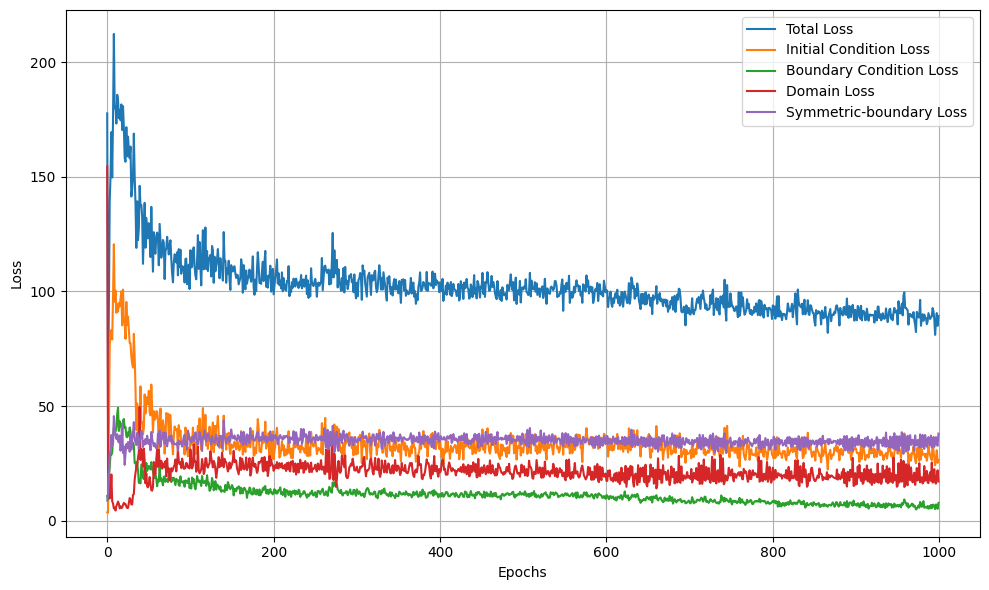

In [858]:
total_loss, loss_IC, loss_BC, loss_domain, loss_BC_symmetric = model.get_training_history() 

# training/validation losses
plt.figure(figsize=(10, 6))
plt.plot(total_loss, label='Total Loss')
plt.plot(loss_IC, label='Initial Condition Loss')
plt.plot(loss_domain, label='Domain Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [859]:
# Get model predictions after training
n_valid = 20

x_valid = np.linspace(-5, 5, n_valid).reshape(-1,1) # Space domain (must be same space as time one (for shuffle purposes))
t_valid = np.linspace(0, 5, n_valid).reshape(-1,1) # Time domain

X_valid, T_valid = np.meshgrid(x_valid[:, 0], t_valid[:, 0]) 

y_true_valid = exactSolution(T_valid, X_valid) 

x_valid = standardize(x_valid)
t_valid = standardize(t_valid)
y_true_valid = standardize(y_true_valid)

X_valid, T_valid = np.meshgrid(x_valid[:, 0], t_valid[:, 0])                                                                                                  

idx = torch.randperm(n_valid)

x_val = x_valid[idx]
t_val = t_valid[idx]

X_val, T_val = np.meshgrid(x_val[:, 0], t_val[:, 0])

t_pred = torch.tensor(T_val.flatten(), requires_grad=True).view(-1, 1).float().to(device)
x_pred = torch.tensor(X_val.flatten(), requires_grad=True).view(-1, 1).float().to(device)

# Predict with the trained model
y_pred = model.network_prediction(t_pred, x_pred).cpu().detach().numpy()

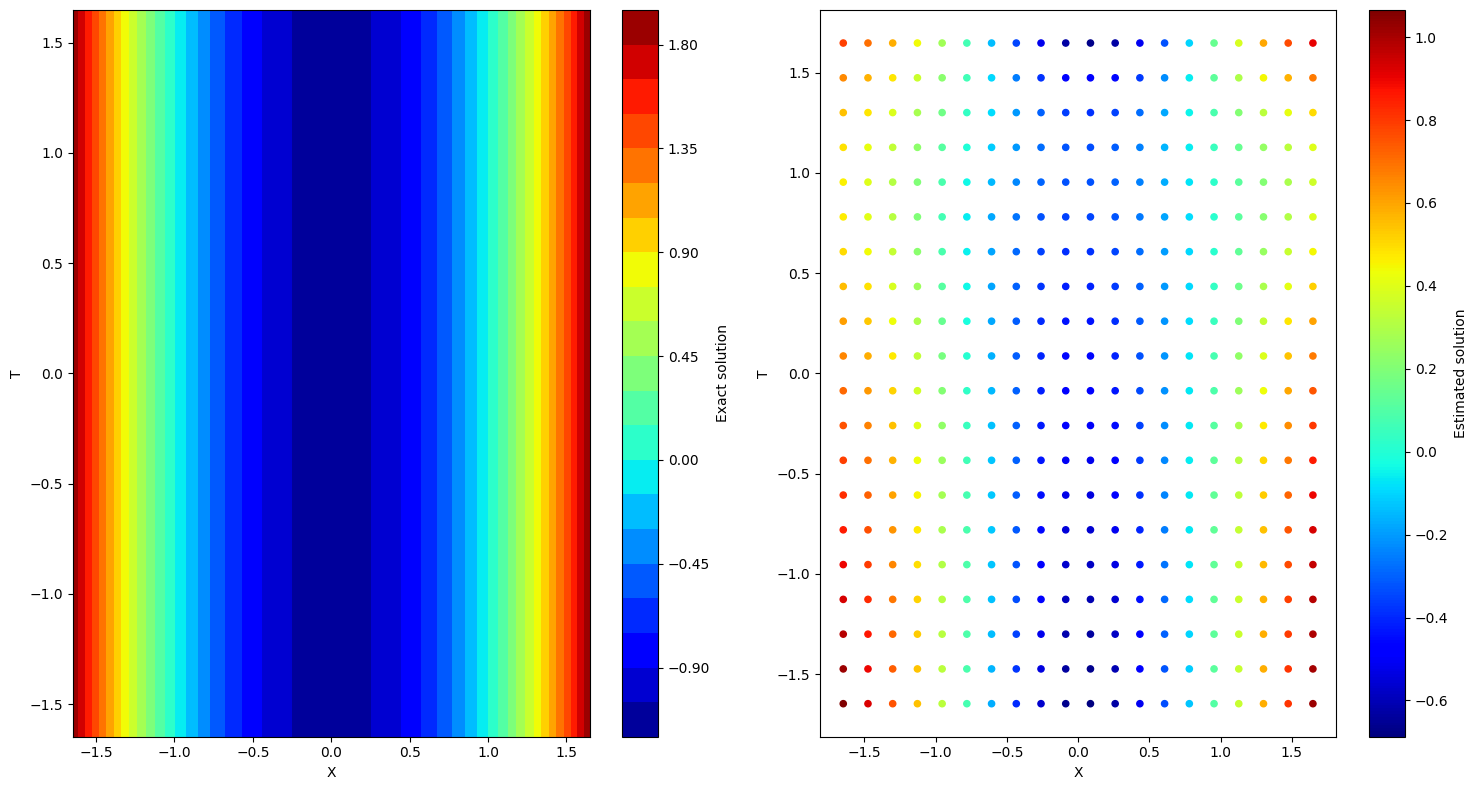

In [863]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

# Subplot 1: Plot true values (exact solution)
c1 = axes[0].contourf(X_valid, T_valid, y_true_valid, levels=int(n_valid), cmap='jet', alpha=1)
axes[0].set_xlabel('X')
axes[0].set_ylabel('T')
fig.colorbar(c1, ax=axes[0], label='Exact solution')

# Subplot 2: Plot only predictions (estimated solution)
c2 = axes[1].scatter(X_val, T_val, c=y_pred, cmap='jet', s=n_valid, alpha=1)
axes[1].set_xlabel('X')
axes[1].set_ylabel('T')
fig.colorbar(c2, ax=axes[1], label='Estimated solution')

plt.tight_layout()
plt.show()

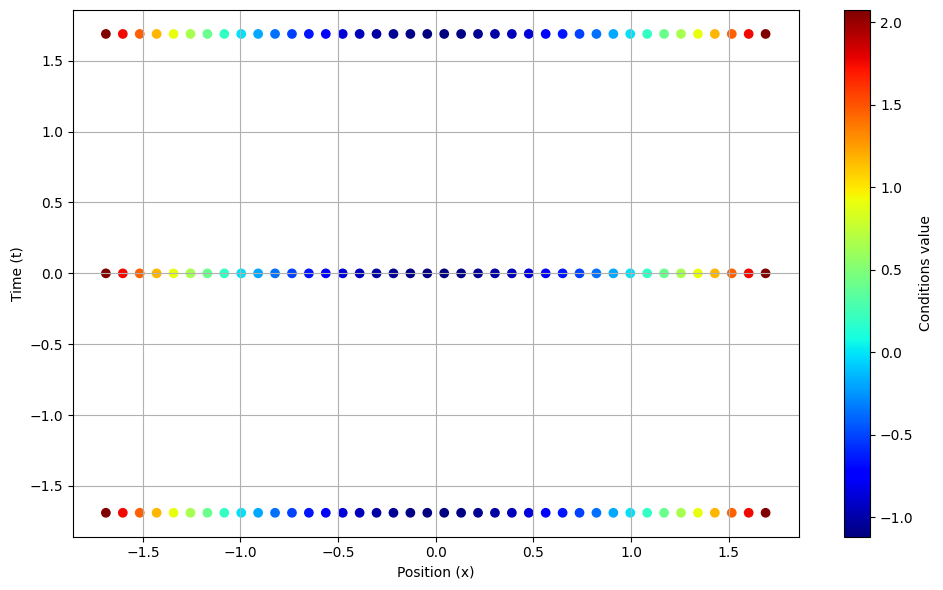

In [861]:
# Plot Initial conditions and Boundary conditions
plt.figure(figsize=(10, 6))
plt.scatter(x0.detach().numpy(), t0.detach().numpy(), c=y0.flatten(), cmap='jet')
plt.colorbar(label='Conditions value')
plt.xlabel('Position (x)')
plt.ylabel('Time (t)')
plt.grid(True)
plt.tight_layout()
plt.show()